In [93]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

Two steps here: load the NPZ files then subset the arrays. We end up with two arrays. x=images, y=labels

In [94]:
# Load npz file containing image arrays
x_npz = np.load("/volumes/data/chest_xray/numpy_array/x_images_arrays.npz")
x = x_npz['arr_0']
# Load binary encoded labels for Lung Infiltrations: 0=Not_infiltration 1=Infiltration
y_npz = np.load("/volumes/data/chest_xray/numpy_array/y_infiltration_labels.npz")
y = y_npz['arr_0']

In [168]:
# Split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

X_train = X_train * 1./255.  #Getting data in 0-1 range
X_val = X_val * 1./255.

print(np.array(X_train).shape)
print(np.array(X_val).shape)
print('Number of images of no disease found in training: ', sum(y_train == 1))
print('Number of images of disease found in training: ', sum(y_train == 0))

(4484, 128, 128, 3)
(1122, 128, 128, 3)
Number of images of no disease found in training:  2435
Number of images of disease found in training:  2049


### Setting up the model in Keras

In [104]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

K.image_data_format()

'channels_last'

In [97]:
img_width, img_height = 128, 128
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
epochs = 10
batch_size = 16

In [148]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.Dense(1, name='preds'))
# model.add(layers.BatchNormalization())
model.add(layers.Activation("sigmoid"))

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_21 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
activation_22 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_22 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
activation_23 (Activation)   (None, 61, 61, 64)        0         
__________

### Data augmentation

I'm rescaling the values by 1/255.  
Randomly flipping images horizontally  
Randomly rotating in a range of 30 degrees  

In [149]:
train_datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=30)
val_datagen = ImageDataGenerator()


train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(np.array(X_val), y_val, batch_size=batch_size)

In [150]:
model_checkpoint = ModelCheckpoint('training_balanced_weights.h5', monitor='val_loss', save_best_only=True)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=[model_checkpoint],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
)

model.load_weights('training_balanced_weights.h5')
model.save('binary_model_1.h5')

Epoch 1/10
280/280 [==============================] - 27s - loss: 0.6961 - acc: 0.5685 - val_loss: 0.6526 - val_acc: 0.6348
Epoch 2/10
280/280 [==============================] - 16s - loss: 0.6725 - acc: 0.5922 - val_loss: 0.6570 - val_acc: 0.6067
Epoch 3/10
280/280 [==============================] - 16s - loss: 0.6584 - acc: 0.6103 - val_loss: 0.6527 - val_acc: 0.6175
Epoch 4/10
280/280 [==============================] - 17s - loss: 0.6549 - acc: 0.6163 - val_loss: 0.6524 - val_acc: 0.6094
Epoch 5/10
280/280 [==============================] - 17s - loss: 0.6573 - acc: 0.6179 - val_loss: 0.6253 - val_acc: 0.6600
Epoch 6/10
280/280 [==============================] - 16s - loss: 0.6497 - acc: 0.6208 - val_loss: 0.6303 - val_acc: 0.6609
Epoch 7/10
280/280 [==============================] - 16s - loss: 0.6520 - acc: 0.6234 - val_loss: 0.6971 - val_acc: 0.5787
Epoch 8/10
280/280 [==============================] - 16s - loss: 0.6461 - acc: 0.6283 - val_loss: 0.6351 - val_acc: 0.6573
Epoch 9/

In [151]:
def plot_history(history):
    plt.rcParams["figure.figsize"] = [15,5]
    # summarize history for loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss']), plt.plot(history.history['val_loss'])
    plt.title(' model loss'), plt.ylabel('loss'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right',prop={'size': 12})
    # summarize history for accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['acc']), plt.plot(history.history['val_acc'])
    plt.title(' model accuracy'), plt.ylabel('accuracy'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right',prop={'size': 12})
    plt.show()
    print('Last epoch train accuracy:', history.history['acc'][-1])
    print('Last epoch test accuracy:', history.history['val_acc'][-1])

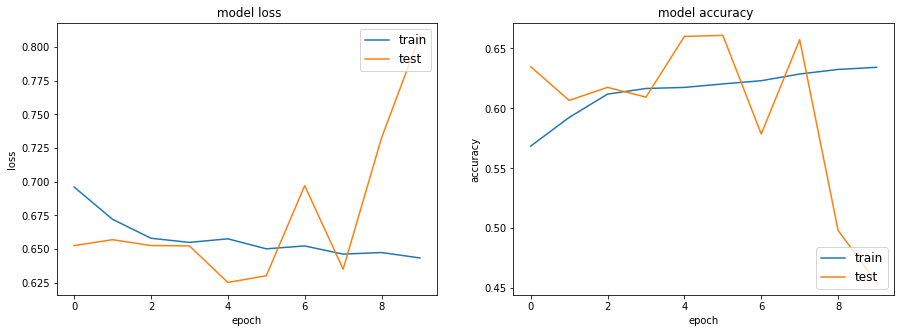

Last epoch train accuracy: 0.634288272158
Last epoch test accuracy: 0.4547920434


In [152]:
plot_history(history)

In [169]:
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)
from sklearn.metrics import confusion_matrix

print('Predicting on test data')
y_pred = np.rint(model.predict(X_val))

print('Confusion Matrix: '+'\n', confusion_matrix(y_val, y_pred))

Predicting on test data
Confusion Matrix: 
 [[  0 513]
 [  0 609]]


In [153]:
y_val[:4]

array([0, 1, 0, 0])

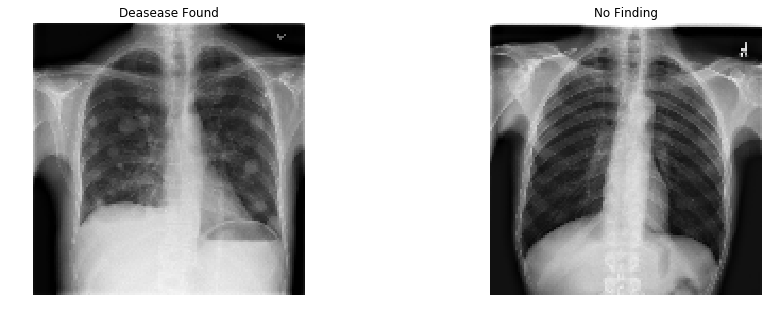

In [154]:
img1 = X_val[0,...]
img2 = X_val[1,...]

plt.subplot(121)
plt.imshow(img1), plt.title('Deasease Found'), plt.axis('off')

plt.subplot(122)
plt.imshow(img2), plt.title('No Finding'), plt.axis('off');

### Class Activation Maps

What is a Class Activation Map?
Class activation maps or grad-CAM is another way of visualizing attention over input. Instead of using gradients with respect to output (see saliency), grad-CAM uses penultimate (pre Dense layer) Conv/Pooling layer (nearest layer with filters). The intuition is to use the nearest Conv layer to utilize spatial information that gets completely lost in Dense layers.

https://github.com/raghakot/keras-vis/blob/master/examples/vggnet/attention.ipynb  
https://github.com/raghakot/keras-vis/blob/master/examples/mnist/attention.ipynb  
https://github.com/raghakot/keras-vis/blob/master/applications/self_driving/visualize_attention.ipynb  

In [155]:
from vis.utils import utils
from keras import activations
import matplotlib.cm as cm
from vis.visualization import visualize_cam, visualize_saliency, overlay


# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
# layer_idx = utils.find_layer_idx(model, 'preds')
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

#### Grad CAM Visualization

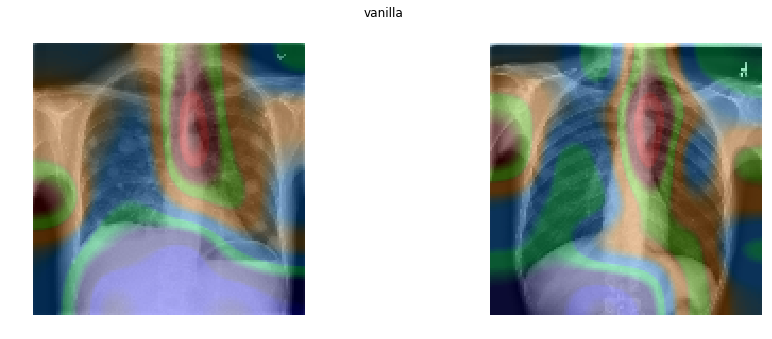

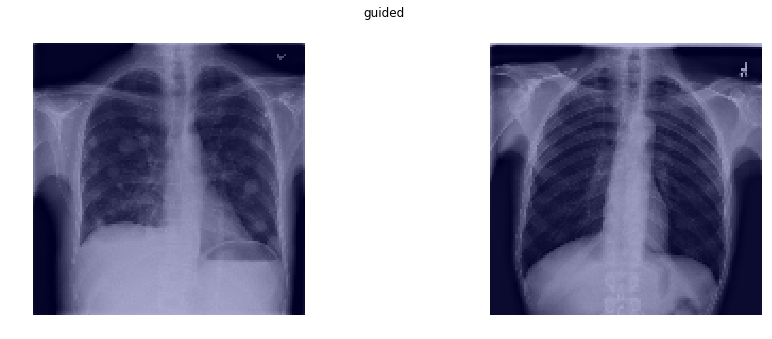

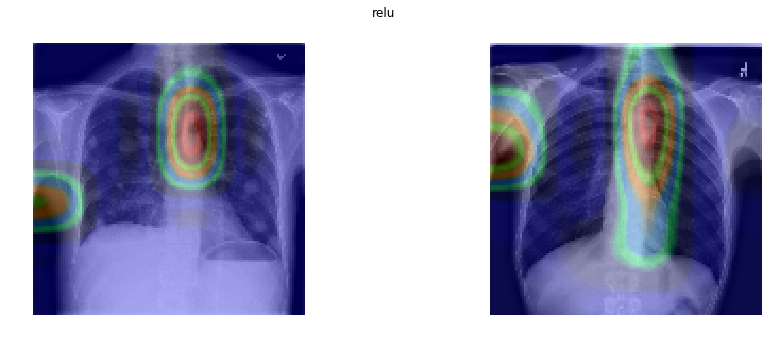

In [156]:
for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        grads = visualize_cam(model, layer_idx, filter_indices=[0], 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)*255)[:, : , :, 0]
        ax[i].imshow(overlay(jet_heatmap, img*255, alpha = 0.4)), ax[i].set_axis_off()

#### Saliency Maps Visualization

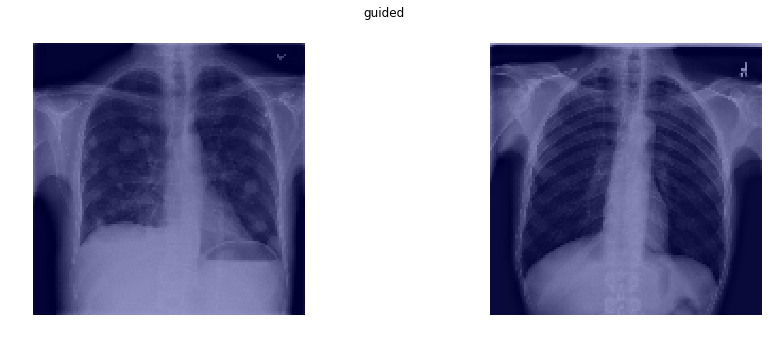

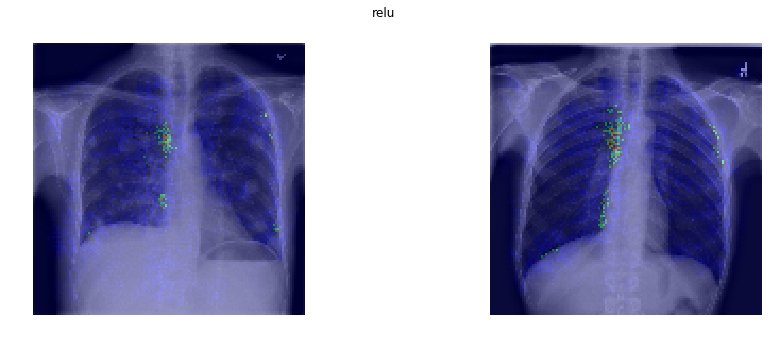

In [157]:
for modifier in ['guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_saliency(model, layer_idx, filter_indices=[0], 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)*255)[:, : , :, 0]
        ax[i].imshow(overlay(jet_heatmap, img*255, alpha = 0.4)), ax[i].set_axis_off()

### Visualizing activations

In [171]:
from vis.visualization import visualize_activation
from vis.input_modifiers import Jitter
from vis.visualization import get_num_filters

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_21 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
activation_22 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_22 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
activation_23 (Activation)   (None, 61, 61, 64)        0         
__________

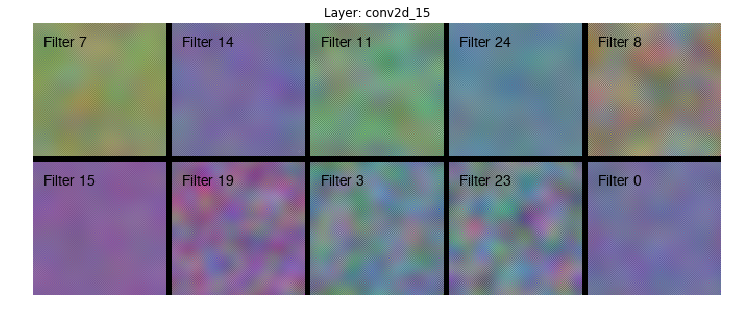

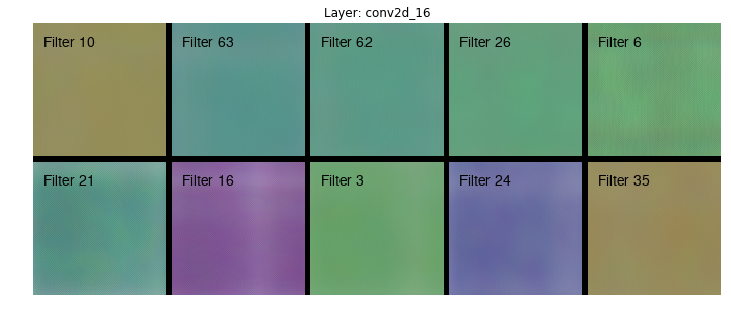

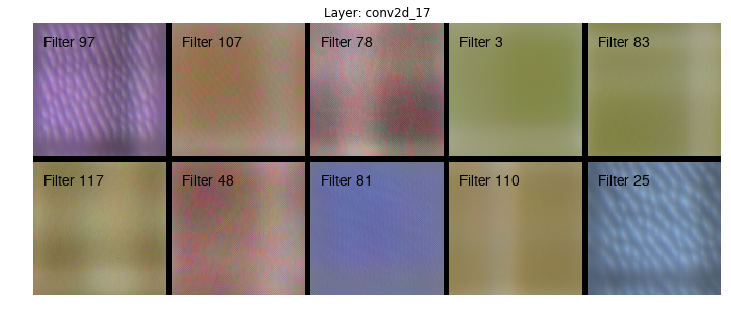

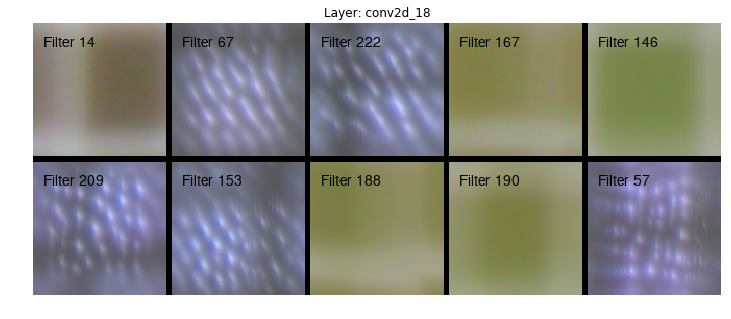

In [176]:
# layer_idx = utils.find_layer_idx(model, 'preds')
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

selected_indices = []
for layer_name in ['conv2d_15', 'conv2d_16', 'conv2d_17', 'conv2d_18']:
    layer_idx = utils.find_layer_idx(model, layer_name)

    # Visualize all filters in this layer.
    filters = np.random.permutation(get_num_filters(model.layers[layer_idx]))[:10]
    selected_indices.append(filters)

    # Generate input image for each filter.
    vis_images = []
    for idx in filters:
        img = visualize_activation(model, layer_idx, filter_indices=idx, input_modifiers=[Jitter(0.05)])

        # Utility to overlay text on image.
        img = utils.draw_text(img, 'Filter {}'.format(idx))    
        vis_images.append(img)

    # Generate stitched image palette with 5 cols so we get 2 rows.
    stitched = utils.stitch_images(vis_images, cols=5)    
    plt.figure()
    plt.imshow(stitched), plt.axis('off'), plt.title('Layer: '+layer_name)
    plt.show()

#### Visualizing dense layer activations

https://github.com/raghakot/keras-vis/blob/master/examples/vggnet/activation_maximization.ipynb  
https://github.com/raghakot/keras-vis/blob/master/examples/mnist/activation_maximization.ipynb  

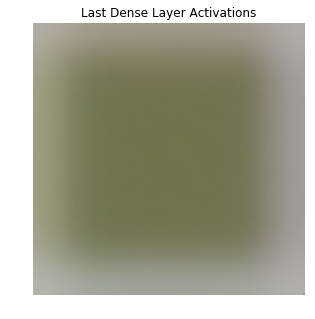

In [182]:
img = visualize_activation(model, layer_idx, filter_indices=[0], max_iter=500)
plt.imshow(img), plt.axis('off'), plt.title('Last Dense Layer Activations');